In [1]:
import pandas as pd
import nltk
import re
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\willi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
data = pd.read_csv("Dataset.csv")
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
data["sentiment"].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [5]:
ps = PorterStemmer()

In [6]:
corpus = []
for i in range(len(data)):
    print(f"Processing Review: {i+1}",end="\r")
    review = re.sub("[^a-zA-Z]"," ",data["review"][i])

    review = review.lower()
    review = review.split()

    review = [ps.stem(r) for r in review if r not in stopwords.words("english")]

    review = " ".join(review)

    corpus.append(review)

In [7]:
with open("corpus.pkl","wb") as f:
    pickle.dump(corpus,f)

In [10]:
tfidf = TfidfVectorizer(max_features=5000)
tfidf = tfidf.fit(corpus)


In [259]:
with open("vectorizer.pkl","wb") as f:
    pickle.dump(tfidf,f)

In [11]:
X = tfidf.transform(corpus).toarray()

In [12]:
y = pd.get_dummies(data['sentiment'])

In [13]:
y = y.iloc[:,1].values #positive - 1 negative - 0

In [14]:
import numpy as np

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)


Naive Bayes Model

In [16]:
from sklearn.naive_bayes import MultinomialNB

In [17]:
nbmodel = MultinomialNB()

In [18]:
nbmodel = nbmodel.fit(X_train,y_train)

In [19]:
nb_y_pred = nbmodel.predict(X_test)

In [20]:
nb_y_train_pred = nbmodel.predict(X_train)

In [21]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,nb_y_pred)

array([[4132,  773],
       [ 734, 4361]], dtype=int64)

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,nb_y_pred)

0.8493

In [23]:
accuracy_score(y_train,nb_y_train_pred)

0.85945

In [24]:
confusion_matrix(y_train,nb_y_train_pred)

array([[17209,  2886],
       [ 2736, 17169]], dtype=int64)

*Logistic Regression*

In [172]:
from sklearn.linear_model import LogisticRegression

In [173]:
lomodel = LogisticRegression()

In [174]:
lomodel = lomodel.fit(X_train,y_train)

In [175]:
lo_y_pred = lomodel.predict(X_test)

In [176]:
lo_y_train_pred = lomodel.predict(X_train)

In [177]:
confusion_matrix(y_test,lo_y_pred)

array([[4295,  610],
       [ 504, 4591]], dtype=int64)

In [178]:
accuracy_score(y_test,lo_y_pred)

0.8886

In [179]:
accuracy_score(y_train,lo_y_train_pred)

0.91

In [180]:
confusion_matrix(y_train,lo_y_train_pred)

array([[18100,  1995],
       [ 1605, 18300]], dtype=int64)

Keras model

In [25]:
keras_X_train = np.expand_dims(X_train,2)

In [26]:
keras_y_train = np.expand_dims(y_train,1)

In [249]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dropout,LSTM,Conv1D,MaxPooling1D,Flatten,Dense,BatchNormalization,SimpleRNN,Embedding,Input
from keras.callbacks import EarlyStopping

In [250]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

kerasmodel = Sequential()

kerasmodel.add(Conv1D(32,(3),input_shape=(5000,1),activation="relu"))
kerasmodel.add(Conv1D(32,(3),activation="relu"))
kerasmodel.add(Dropout(0.4))
kerasmodel.add(MaxPooling1D((2)))

kerasmodel.add(Flatten())
kerasmodel.add(Dropout(0.4))
kerasmodel.add(Flatten())


kerasmodel.add(Dense(64,activation="relu"))
kerasmodel.add(Dropout(0.4))
kerasmodel.add(Dense(32,activation="relu"))
kerasmodel.add(Dropout(0.4))
kerasmodel.add(Dense(16,activation="relu"))



kerasmodel.add(Dense(1,activation="sigmoid"))

kerasmodel.summary()

Model: "sequential_345"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_59 (Conv1D)          (None, 4998, 32)          128       
                                                                 
 conv1d_60 (Conv1D)          (None, 4996, 32)          3104      
                                                                 
 dropout_102 (Dropout)       (None, 4996, 32)          0         
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 2498, 32)         0         
 g1D)                                                            
                                                                 
 flatten_43 (Flatten)        (None, 79936)             0         
                                                                 
 dropout_103 (Dropout)       (None, 79936)             0         
                                                    

In [251]:
kerasmodel.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

In [252]:
try:
    history  = kerasmodel.fit(keras_X_train,keras_y_train,batch_size=256,epochs=15,validation_split=0.15,callbacks=[callback])
except KeyboardInterrupt:
    del kerasmodel
    print("\n[info] Model Deleted")

Epoch 1/15
133/133 [==============================] - 123s 921ms/step - loss: 0.4852 - accuracy: 0.7634 - val_loss: 0.3219 - val_accuracy: 0.8627
Epoch 2/15
133/133 [==============================] - 123s 926ms/step - loss: 0.3226 - accuracy: 0.8691 - val_loss: 0.3037 - val_accuracy: 0.8685
Epoch 3/15
133/133 [==============================] - 123s 925ms/step - loss: 0.2835 - accuracy: 0.8849 - val_loss: 0.2958 - val_accuracy: 0.8747
Epoch 4/15
133/133 [==============================] - 126s 951ms/step - loss: 0.2599 - accuracy: 0.8968 - val_loss: 0.2998 - val_accuracy: 0.8688
Epoch 5/15
133/133 [==============================] - 123s 926ms/step - loss: 0.2374 - accuracy: 0.9076 - val_loss: 0.2909 - val_accuracy: 0.8760
Epoch 6/15
133/133 [==============================] - 123s 927ms/step - loss: 0.2134 - accuracy: 0.9172 - val_loss: 0.3054 - val_accuracy: 0.8720
Epoch 7/15
133/133 [==============================] - 123s 925ms/step - loss: 0.1929 - accuracy: 0.9275 - val_loss: 0.3140 -

In [65]:
import matplotlib.pyplot as plt

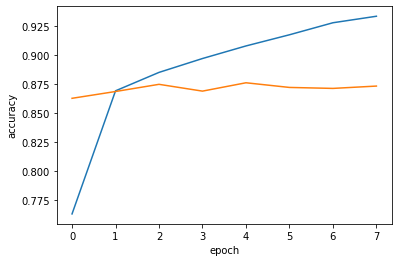

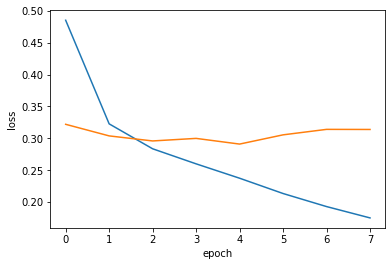

In [253]:
plt.plot(history.history['accuracy'],label="Training Accuracy")
plt.plot(history.history['val_accuracy'],label="Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
# plotting training and validation loss
plt.plot(history.history['loss'],label = "Training Loss")
plt.plot(history.history['val_loss'],label = "Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [254]:
keras_y_pred = kerasmodel.predict(X_test)

313/313 [==============================] - 6s 18ms/step


In [255]:
keras_y_pred = [round(float(i)) for i in keras_y_pred]

In [262]:
accuracy_score(y_test,keras_y_pred)

0.8758

In [257]:
confusion_matrix(y_test,keras_y_pred)

array([[4306,  599],
       [ 643, 4452]], dtype=int64)

In [258]:
kerasmodel.save("keras-model8")

INFO:tensorflow:Assets written to: keras-model8\assets


INFO:tensorflow:Assets written to: keras-model8\assets
